In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
import numpy as np 
import scipy.fft
from operators.hermite.setup_hermite import SimulationSetupHermite
from operators.poisson_solver import gmres_solver
from operators.hermite.hermite_operators import psi_ln_aw, charge_density, total_mass, total_momentum, total_energy_k

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import matplotlib
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Hermite weak Landau damping 

In [6]:
setup = SimulationSetupHermite(Nx=151,
                               Nv=50,
                               epsilon=1e-2,
                               alpha_e=0.75,
                               alpha_i=np.sqrt(2 / 1836),
                               u_e=0,
                               u_i=0,
                               L=2 * np.pi,
                               dt=1e-2,
                               T0=0,
                               T=200,
                               nu=10)

In [7]:
# ions (unperturbed)
C0_ions = np.ones(setup.Nx) / setup.alpha_i

In [8]:
# velocity grid for plotting purposes
v = np.linspace(-3, 3, int(10**4))
# spatial grid 
x = np.linspace(0, setup.L, setup.Nx+1)

# simulation results

In [10]:
skip = 1
# load the simulation results
# save results
sol_midpoint_u = np.load("../data/hermite/weak_landau/sol_u_Nv_" + str(setup.Nv) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
sol_midpoint_t = np.load("../data/hermite/weak_landau/sol_FOM_t_Nv_" + str(setup.Nv) + "_Nx_" + str(setup.Nx) + "_" + str(setup.T0) + "_" + str(setup.T) + ".npy")

dt = 0.01 * skip

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

FileNotFoundError: [Errno 2] No such file or directory: '../data/hermite/weak_landau/sol_u_Nv_50_Nx_151_0_200.npy'

In [47]:
runtime = np.load("../data/FOM/weak_landau/sample_" + str(setup.alpha_e) + "/sol_FOM_u_" + str(setup.Nv) + "_alpha_" + str(setup.alpha_e) + "_runtime_" + str(setup.T0) + "_" + str(setup.T) + ".npy")
runtime

array([1846.31801   ,  334.11947966])

In [48]:
# initialize the electric potential
E_midpoint = np.zeros((setup.Nx + 1, len(sol_midpoint_t)))

In [49]:
# initialize the states for implicit midpoint (symplectic)
state_e_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((setup.Nv,  setup.Nx + 1, len(sol_midpoint_t)))

# unwind the flattening to solve the Vlasov-Poisson system
# electrons
state_e_midpoint[:, :-1, :] = np.reshape(sol_midpoint_u, (setup.Nv, setup.Nx, len(sol_midpoint_t)))
# periodicity enforced
state_e_midpoint[:, -1, :] = state_e_midpoint[:, 0, :]

for ii in np.arange(0, len(sol_midpoint_t)):
    # immobile ions
    state_i_midpoint[0, :-1, ii] = C0_ions
    # periodicity enforced
    state_i_midpoint[0, -1, ii] = state_i_midpoint[0, 0, ii]

    # solve Poisson's equation to obtain an electric field
    rho = charge_density(alpha_e=setup.alpha_e, alpha_i=setup.alpha_i,
                                        q_e=setup.q_e, q_i=setup.q_i,
                                        C0_e=state_e_midpoint[0, :setup.Nx, ii],
                                        C0_i=C0_ions)
    
    E_midpoint[:-1, ii] = gmres_solver(rhs=rho, D=setup.D, D_inv=setup.D_inv, atol=1e-12, rtol=1e-12)
    E_midpoint[-1, ii] = E_midpoint[0, ii]

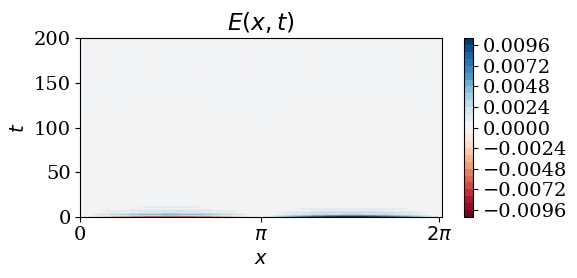

In [50]:
# plot the electric field
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.contourf(x, sol_midpoint_t, E_midpoint.T, cmap="RdBu", levels=30)
cbar = fig.colorbar(pos)
ax.set_title("$E(x, t)$")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi-.05])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()

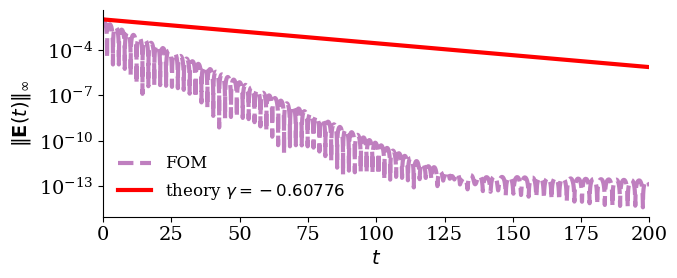

In [51]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, np.max(E_midpoint, axis=0), "--", c="purple", alpha=0.5, linewidth=3, label="FOM") 
ax.plot(sol_midpoint_t, 0.01*np.exp(-0.0362*sol_midpoint_t), linewidth=3, color="red", label=r"theory $\gamma = -0.60776$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\|\mathbf{E}(t)\|_{\infty}$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, setup.T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='lower left')
legend.get_frame().set_alpha(0)
plt.tight_layout()

In [52]:
# save the electric field
np.save("../data/FOM/weak_landau/sample_" + str(setup.alpha_e) + "/E_FOM_" + str(setup.Nv) + ".npy", E_midpoint)
np.save("../data/FOM/weak_landau/sample_" + str(setup.alpha_e) + "/N_FOM_" + str(setup.Nv) + ".npy", state_e_midpoint[0, :, :])

# conservation laws: mass, momentum, and energy

### mass conservation

In [62]:
# compute mass at each timestamp
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx)\
                        +total_mass(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx)

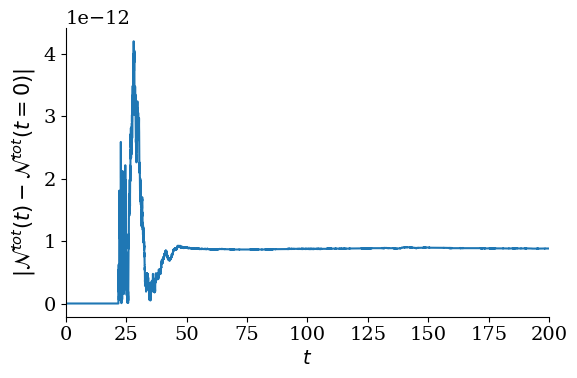

In [63]:
# plot mass conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(mass_midpoint - mass_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{N}^{tot}(t) - \mathcal{N}^{tot}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
plt.tight_layout()

### momentum conservation

In [64]:
# compute momentum at each timestamp
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx,
                                           m_s=setup.m_e, u_s=setup.u_e)\
                            +total_momentum(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx,
                                           m_s=setup.m_i, u_s=setup.u_i)

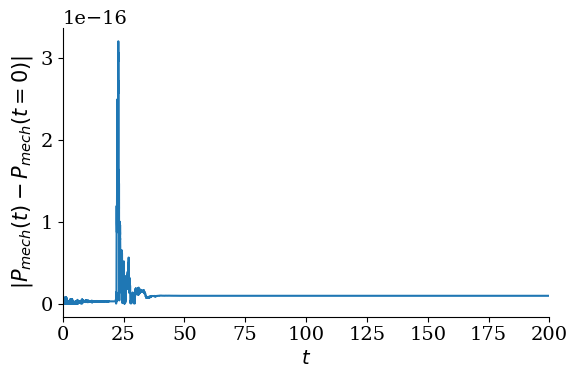

In [65]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
#ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlim(setup.T0, setup.T)
ax.set_xlabel("$t$")
plt.tight_layout()

### energy conservation

In [66]:
# compute energy (kinetic + potential) at each timestamp
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e_midpoint[:, :-1, ii], alpha_s=setup.alpha_e, dx=setup.dx, m_s=setup.m_e, u_s=setup.u_e)\
                           +total_energy_k(state=state_i_midpoint[:, :-1, ii], alpha_s=setup.alpha_i, dx=setup.dx, m_s=setup.m_i, u_s=setup.u_i)
    
    energy_p_midpoint[ii] = 0.5*setup.dx*np.sum((E_midpoint[:-1, ii])**2)

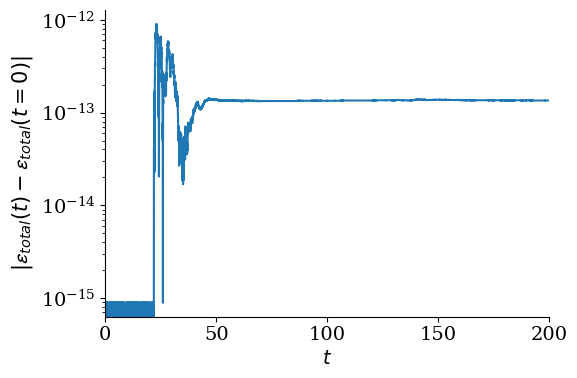

In [67]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
plt.tight_layout()

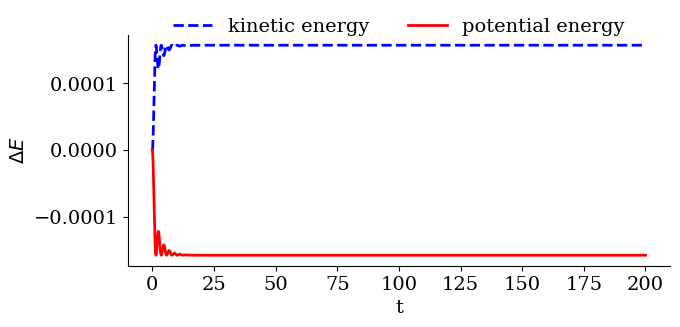

In [68]:
# plot the (kinetic + potential) energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy", ls="--", linewidth=2, color="blue")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy", linewidth=2, color="red")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.15))
legend.get_frame().set_alpha(0)
#ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\Delta E$")

### conservation summary

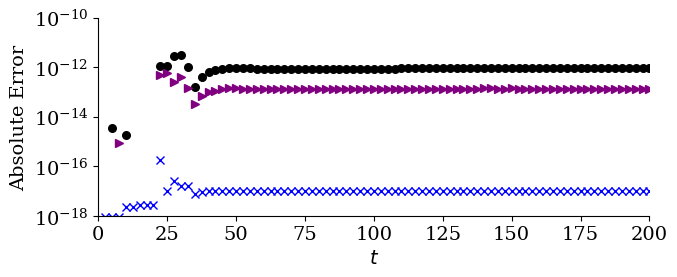

In [69]:
# plot the analytic and numerical conservation properties
skip = 250

fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::skip], np.abs(mass_midpoint-mass_midpoint[0])[::skip], s=30, color="black", label=r"mass $\mathcal{M}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(momentum_midpoint-momentum_midpoint[0])[::skip], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::skip], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::skip], ">", color="purple", label=r"energy $\mathcal{E}(t)$")

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_ylim(1e-18, 1e-10) 
ax.set_xlabel("$t$")
ax.set_xlim(setup.T0, setup.T)
ax.set_yscale("log")
# legend = ax.legend(ncols=2, fontsize=14, loc='upper center')
# text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
# legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/FOM/weak_landau/conservation_weak_landau_FOM_" + str(setup.alpha_e) + ".png",  bbox_inches='tight', dpi=600)

## Parameteric study 

In [70]:
alpha_train = [0.6, 0.7, 0.8, 0.9]
alpha_test  = [0.5, 0.75]

In [71]:
colors_train = plt.cm.viridis(np.linspace(0,1,len(alpha_train)))
colors_test = plt.cm.viridis(np.linspace(0,1,len(alpha_test)))

In [72]:
E_train = np.zeros((len(alpha_train), setup.Nx + 1, 1001))
E_test = np.zeros((len(alpha_train), setup.Nx + 1, 8001))

for kk in range(0, len(alpha_test)):
    # update the standard deviation parameter 
    alpha_curr = alpha_test[kk]
    E_test[kk, :, :] = np.load("../data/FOM/weak_landau/sample_" + str(alpha_curr) + "/sol_midpoint_E_" + str(setup.Nv) + ".npy")

for kk in range(0, len(alpha_train)):
    # update the standard deviation parameter 
    alpha_curr = alpha_train[kk]
    E_train[kk, :, :] = np.load("../data/FOM/weak_landau/sample_" + str(alpha_curr) + "/sol_midpoint_E_" + str(setup.Nv) + ".npy")

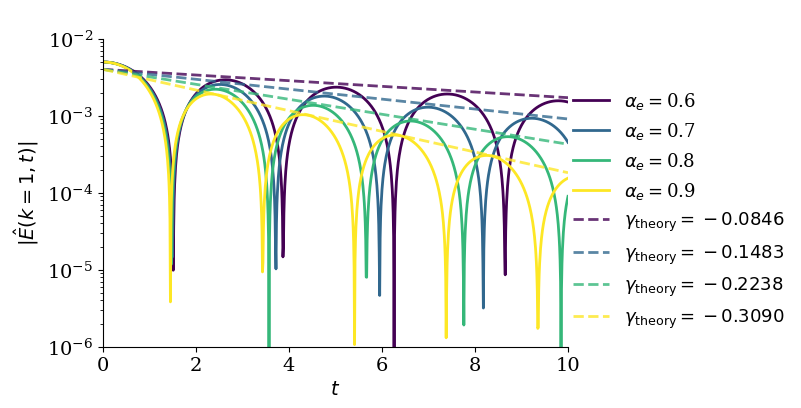

In [73]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 4))
for kk in range(0, len(alpha_train)):
    ax.plot(setup.t_vec[:1001], np.abs(np.fft.fft(E_train[kk, :, :], axis=0, norm="forward")[1, :]), "-", linewidth=2, color=colors_train[kk], label=r"$\alpha_{e}=$" + str(round(alpha_train[kk], 1)))

ax.plot(setup.t_vec[:1001], 0.004* np.exp(-0.08467*sol_midpoint_t[:1001]), linewidth=2, ls="--", color=colors_train[0], alpha=0.8, label="$\gamma_{\mathrm{theory}} = -0.0846$") 
ax.plot(setup.t_vec[:1001], 0.004*np.exp(-0.14835*sol_midpoint_t[:1001]), linewidth=2, ls="--", color=colors_train[1], alpha=0.8, label="$\gamma_{\mathrm{theory}} = -0.1483$") 
ax.plot(setup.t_vec[:1001], 0.004*np.exp(-0.2238*sol_midpoint_t[:1001]), linewidth=2, ls="--", color=colors_train[2], alpha=0.8, label="$\gamma_{\mathrm{theory}} =-0.2238$") 
ax.plot(setup.t_vec[:1001], 0.004*np.exp(-0.309001*sol_midpoint_t[:1001]), linewidth=2, ls="--", color=colors_train[3], alpha=0.8, label="$\gamma_{\mathrm{theory}} = -0.3090$") 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\hat{E}(k=1, t)|$")
ax.set_xlabel("$ t$")
ax.set_xlim(0, 10)
ax.set_yticks([1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
ax.set_ylim(1e-6, 1e-2)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=13, loc='lower right', bbox_to_anchor=(1.5, 0))
legend.get_frame().set_alpha(0)
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
plt.savefig("../figs/FOM/weak_landau/weak_landau_electric_field_FOM_train.png", bbox_inches='tight', bbox_extra_artists=(legend,text), pad_inches=0.0, dpi=600)

In [64]:
damping_rates = [-0.08467, -0.14835, -0.2238, -0.309001]


In [98]:
(-0.14835+ -0.2238)/2

-0.186075

In [99]:
alpha_train

[0.6, 0.7, 0.8, 0.9]

In [100]:
coefficients = np.polyfit(alpha_train, damping_rates, 1) # 1 for linear fit
m = coefficients[0] # slope
b = coefficients[1] # intercept

In [101]:
np.polyfit(alpha_train, damping_rates, 1)

array([-0.748443,  0.369877])

In [102]:
m*0.5 + b

-0.0043445000000003064

In [103]:
m*0.75 + b

-0.1914552500000003

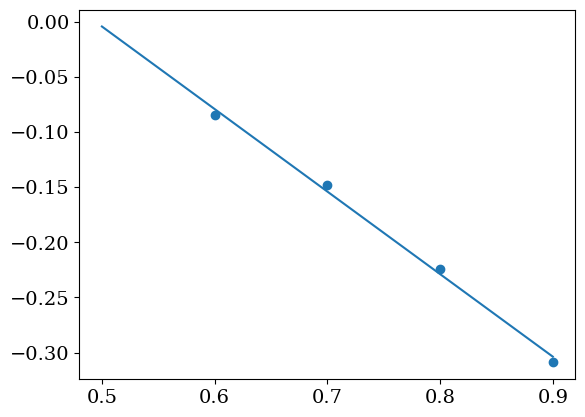

In [104]:
plt.scatter(alpha_train, damping_rates)
plt.plot(np.linspace(0.5, 0.9, 100), m*np.linspace(0.5, 0.9, 100) + b)

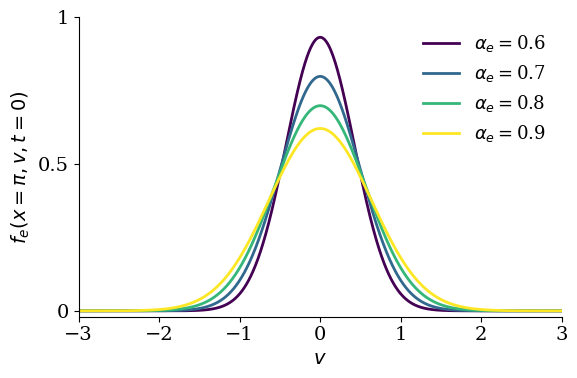

In [48]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 4))
for kk in range(0, len(alpha_train)):
    alpha_e = alpha_train[kk]
    C0_e = (1 + setup.epsilon * np.cos(x)) / alpha_e
    distribution = np.outer(C0_e, psi_ln_aw(v=v, alpha_s=alpha_e, u_s=setup.u_e, n=0))
    ax.plot(v, distribution[setup.Nx//2, :], linewidth=2, color=colors_train[kk], ls="-", label=r"$\alpha_{e}=$" + str(alpha_train[kk]))
    
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=13,  loc='upper right')
legend.get_frame().set_alpha(0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$f_{e}(x=\pi, v, t=0)$")
ax.set_xlabel("$v$")
ax.set_ylim(-2e-2, 1)
ax.set_xlim(-3, 3)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels([0, 0.5, 1])
plt.tight_layout()
plt.savefig("../figs/FOM/weak_landau/weak_landau_initial_condition_cross_section.png", bbox_inches='tight', pad_inches=0.0, dpi=600)

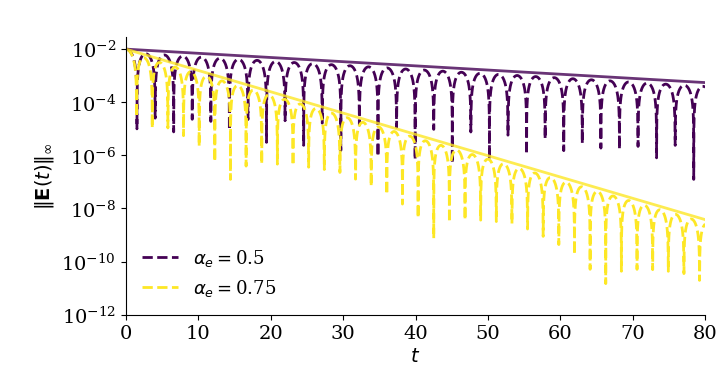

In [27]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(7.5, 4))
for kk in range(0, len(alpha_test)):
    ax.plot(np.linspace(0, 80, 8001), np.max(E_test[kk, :], axis=0), "--", linewidth=2, color=colors_test[kk], label=r"$\alpha_{e}=$" + str(alpha_test[kk]))

ax.plot(np.linspace(0, 80, 8001), 0.01*np.exp(-0.03626*np.linspace(0, 80, 8001)), linewidth=2, color=colors_test[0], alpha=0.8) 
ax.plot(np.linspace(0, 80, 8001), 0.01*np.exp(-0.1848*np.linspace(0, 80, 8001)), linewidth=2, color=colors_test[1], alpha=0.8) 

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\|\mathbf{E}(t)\|_{\infty}$")
ax.set_xlabel("$t$")
ax.set_yticks([1e-2, 1e-4, 1e-6, 1e-8, 1e-10, 1e-12])
ax.set_xlim(0, 80)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=13, loc='lower left')
legend.get_frame().set_alpha(0)
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
plt.tight_layout()

## POD basis 

In [9]:
# for M in range(3, 10):
#     # load the simulation results
#     sol_u_FOM  = np.load("../data/FOM/weak_landau/sample_" + str(alpha_train[0]) + "/sol_FOM_u_" + str(setup.Nv) + "_alpha_" + str(alpha_train[0]) + "_" + str(setup.T0) + "_10.npy")[M*setup.Nx:,:]
#     for kk in range(1, len(alpha_train)):
#         # update the standard deviation parameter 
#         alpha_ = alpha_train[kk]
#         new_data =  np.load("../data/FOM/weak_landau/sample_" + str(alpha_) + "/sol_FOM_u_" + str(setup.Nv) + "_alpha_" + str(alpha_) + "_" + str(setup.T0) + "_10.npy")[M*setup.Nx:, :]
#         sol_u_FOM = np.append(sol_u_FOM, new_data, axis=1)
#     # compute the SVD
#     U, S, _ = np.linalg.svd(sol_u_FOM, full_matrices=False)
#     # save the basis
#     np.save("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/basis_" + str(M) + ".npy", U)
#     np.save("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_" + str(M) + ".npy", S)

In [10]:
S_3 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_3.npy")
S_4 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_4.npy")
S_5 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_5.npy")
S_6 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_6.npy")
S_7 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_7.npy")
S_8 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/singular_values_8.npy")

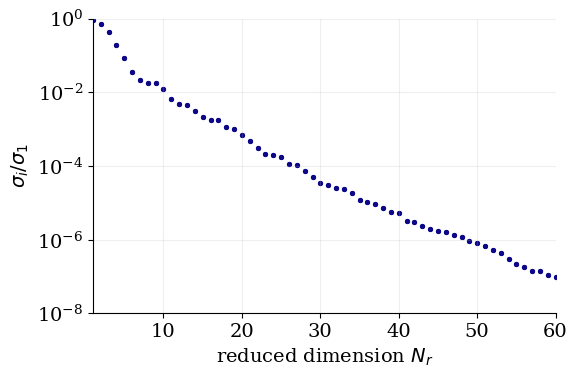

In [11]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 4))

colors = plt.cm.plasma(np.linspace(0,0.9,4))

ax.scatter(np.arange(len(S_3)), (np.abs(S_3)/np.max(S_3[0])), color=colors[0],linewidth=2, s=3)
ax.scatter(np.arange(len(S_3)), (np.abs(S_3)/np.max(S_3[0])), color=colors[0],linewidth=2, s=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$\sigma_{i}/\sigma_{1}$")
ax.set_xlabel(r"reduced dimension $N_{r}$")
ax.set_yscale("log")
ax.set_ylim(10**-8, 1)
ax.set_xlim(1, 60)
plt.grid(alpha=0.2)
# legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=13, loc='upper right')
# legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/weak_landau/singular_value_decay_weak_landau.png", dpi=300, bbox_inches='tight')

In [12]:
svdvals2 = np.sort(S_3)[::-1] ** 2
energy = np.cumsum(svdvals2) / np.sum(svdvals2)

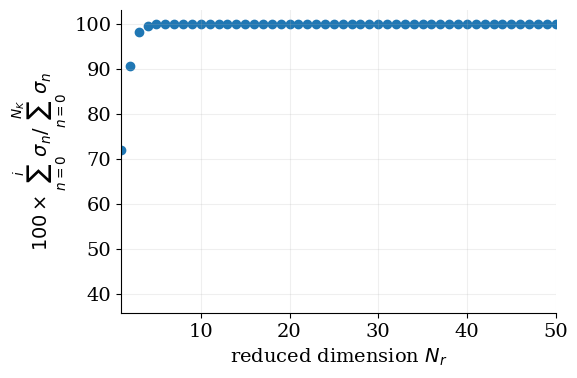

In [41]:
# plot the electric field damping rate
fig, ax = plt.subplots(figsize=(6, 4))

colors = plt.cm.plasma(np.linspace(0,0.9,4))

ax.scatter(np.arange(len(S_3)), 100*energy)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$100 \times \sum_{n=0}^{i}\sigma_{n}/\sum_{n=0}^{N_{K}} \sigma_{n}$")
ax.set_xlabel(r"reduced dimension $N_{r}$")
ax.set_xlim(1, 50)
plt.grid(alpha=0.2)
# legend = ax.legend(ncols=2, fancybox=False, shadow=False, fontsize=13, loc='upper right')
# legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/ROM/weak_landau/cumulative_energy_weak_landau.png", dpi=300, bbox_inches='tight')

In [42]:
energy[50]*100

99.99999999995498

In [9]:
U_3 = np.load("../data/ROM/weak_landau/basis_" + str(setup.Nv) + "/basis_3.npy")

In [32]:
U_3_tensor = np.zeros((setup.Nv - 3, setup.Nx, np.shape(U_3)[-1]))

In [33]:
for n in range(0, setup.Nv - 3):
    U_3_tensor[n, :, :] = U_3[n*setup.Nx: (n+1)*setup.Nx, :]

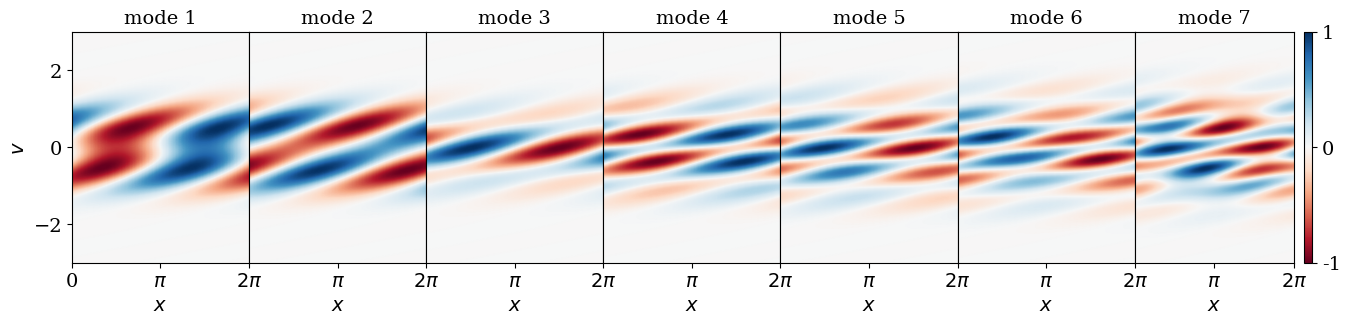

In [34]:
# plot phase space evolution 
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(ncols=7, figsize=(16, 3))
for tt, ii in enumerate([0, 1, 2, 3, 4, 5, 6]):
    distribution = np.zeros((setup.Nx + 1, len(v)))
    for jj in range(setup.Nv - 3):
        distribution += np.outer(np.append(U_3_tensor[jj, :, ii], U_3_tensor[jj, 0, ii]), psi_ln_aw(u_s=setup.u_e, alpha_s=setup.alpha_e, v=v, n=jj))
    pos = ax[tt].pcolormesh(x, v, ((distribution)/np.max(np.abs(distribution))).T, cmap="RdBu", vmax=1, vmin=-1, shading="gouraud")
    ax[tt].set_xlabel("$x$")
    ax[tt].set_ylim(-3, 3)
    ax[tt].set_xticks([np.pi, 2*np.pi])
    ax[tt].set_xticklabels([r"$\pi$", r"$2\pi$"])
    ax[tt].set_yticks([])
    ax[tt].set_title("mode " + str(ii + 1), fontsize=14)

# Create divider for the second subplot
divider = make_axes_locatable(ax[-1])
cax = divider.append_axes("right", size="5%", pad=0.1)

# Add colorbar to the second subplot
cbar = plt.colorbar(pos, cax=cax)
cbar.ax.set_yticks([-1, 0, 1])
cbar.ax.set_yticklabels([-1, 0, 1])
ax[0].set_xticks([0, np.pi, 2*np.pi])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_yticks([-2, 0, 2])
ax[0].set_ylabel("$v$")
plt.subplots_adjust(wspace=0)
#plt.tight_layout()
plt.savefig("../figs/ROM/weak_landau/weak_landau_POD_modes.png", dpi=600, bbox_inches='tight')

# Projection Error 

In [10]:
Y = sol_midpoint_u[3*setup.Nx:, :]

/var/folders/tt/hgb4_vc13z77x5wpt5lzk5j40000gn/T/ipykernel_13575/1564278845.py:7: RuntimeWarning: invalid value encountered in divide
  error = np.linalg.norm(Y - Ur @ Ur.T @ Y, axis=0)/ np.linalg.norm(Y, axis=0)


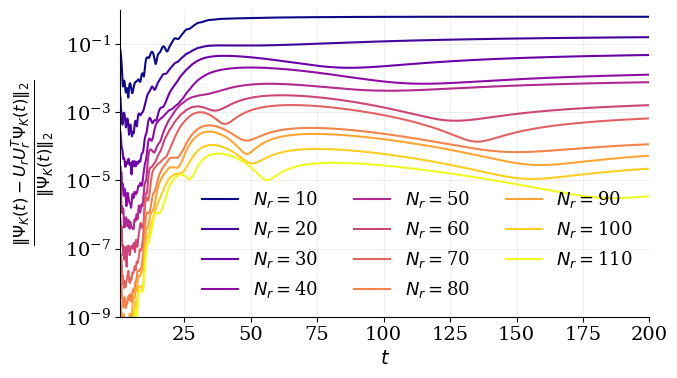

In [11]:
fig, ax = plt.subplots(figsize=(7, 4))

colors = plt.cm.plasma(np.linspace(0,1,11))

for ii, r in enumerate(np.arange(10, 120, 10)):
    Ur = U_3[:, :r]
    error = np.linalg.norm(Y - Ur @ Ur.T @ Y, axis=0)/ np.linalg.norm(Y, axis=0)
    ax.plot(sol_midpoint_t, error, label="$N_{r} =$" + str(r), color=colors[ii])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$ \frac{\|\Psi_{K}(t) - U_{r} U_{r}^{T}  \Psi_{K}(t)\|_{2}}{\|\Psi_{K}(t)\|_{2}}$", fontsize=17)
ax.set_xlabel(r"$t$")
ax.set_yscale("log")
ax.set_xlim(1, 200)
plt.grid(alpha=0.2)
ax.set_yticks([1e-1, 1e-3, 1e-5, 1e-7, 1e-9])
ax.set_ylim(1e-9, 1)
legend = ax.legend(ncols=3, fancybox=False, shadow=False, fontsize=13, loc='lower right')
legend.get_frame().set_alpha(0)

plt.tight_layout()
plt.savefig("../figs/FOM/weak_landau/projection_error_alpha_e_" + str(setup.alpha_e) + ".png", bbox_inches='tight', dpi=300)